### 📄 TRABALHO FINAL DA DISCIPLINA

**Professor:** Romuere Rodrigues Velosos e Silva

**Equipe:**

1. Iago Roberto

2. Francinaldo Barbosa

3. Cristina de Moura

### **ETAPA 0:** Importação de bibliotecas e carregamento dos dados

In [63]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, cohen_kappa_score, confusion_matrix,
    balanced_accuracy_score, matthews_corrcoef,
    ConfusionMatrixDisplay, RocCurveDisplay
)

def moldura(texto: str):
    largura = len(texto) + 4
    print("+" + "-" * (largura - 2) + "+")
    print("| " + texto.center(largura - 4) + " |")
    print("+" + "-" * (largura - 2) + "+")

def add_linha(texto: str, largura_total: int = 90):
    texto = texto.strip()
    if len(texto) + 6 >= largura_total:
        largura_total = len(texto) + 10 

    largura_lados = (largura_total - len(texto) - 4) // 2
    linha = "-" * largura_lados

    if (largura_total - len(texto) - 4) % 2 != 0:
        print(f"\n# {linha} {texto} {linha}- #\n")
    else:
        print(f"\n# {linha} {texto} {linha} #\n")

moldura("Carregando dataset")

ds = fetch_ucirepo(id=519)
X = ds.data.features.copy()
y = ds.data.targets.copy()

# Converter y para array 1D
if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
    y = np.asarray(y).ravel()
else:
    y = np.asarray(y).ravel()

print("X shape:", X.shape, "y shape:", y.shape)

print("Distribuição alvo:")

print(pd.Series(y).value_counts())

+--------------------+
| Carregando dataset |
+--------------------+
X shape: (299, 12) y shape: (299,)
Distribuição alvo:
0    203
1     96
Name: count, dtype: int64


### **ETAPA 1:** Pré-processamento dos dados

In [64]:
moldura("Aplicando pré-processamento...")

X = pd.DataFrame(X).copy()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

unique_classes = np.unique(y)
binary_problem = (len(unique_classes) == 2)

le = LabelEncoder()
y_enc = le.fit_transform(y)

+--------------------------------+
| Aplicando pré-processamento... |
+--------------------------------+


### **ETAPA 2:** Função de avaliação CV

In [65]:
moldura("Iniciando a validação cruzada...")

def evaluate_cv_metrics(clf, X_arr, y_arr, skf):
    """
    Retorna dicionário com métricas por fold e agregadas (mean/std).
    Escala é feita DENTRO de cada fold para evitar data leakage.
    """
    metrics_per_fold = {
        'accuracy': [], 'f1': [], 'precision': [], 'recall': [],
        'roc_auc': [], 'kappa': [], 'balanced_accuracy': [], 'mcc': []
    }

    for train_idx, test_idx in skf.split(X_arr, y_arr):
        X_train, X_test = X_arr[train_idx], X_arr[test_idx]
        y_train, y_test = y_arr[train_idx], y_arr[test_idx]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        clf.fit(X_train_s, y_train)

        # predições
        y_pred = clf.predict(X_test_s)
        
        # probabilidades
        prob = None
        try:
            prob = clf.predict_proba(X_test_s)
            if prob.shape[1] == 2:
                prob = prob[:, 1]
        except:
            prob = None

        # métricas
        if binary_problem:
            metrics_per_fold['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics_per_fold['f1'].append(f1_score(y_test, y_pred))
            metrics_per_fold['precision'].append(precision_score(y_test, y_pred, zero_division=0))
            metrics_per_fold['recall'].append(recall_score(y_test, y_pred, zero_division=0))
            metrics_per_fold['kappa'].append(cohen_kappa_score(y_test, y_pred))
            metrics_per_fold['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
            metrics_per_fold['mcc'].append(matthews_corrcoef(y_test, y_pred))
            if prob is not None:
                try:
                    metrics_per_fold['roc_auc'].append(roc_auc_score(y_test, prob))
                except:
                    metrics_per_fold['roc_auc'].append(np.nan)
            else:
                metrics_per_fold['roc_auc'].append(np.nan)
        else:
            # multiclass
            metrics_per_fold['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics_per_fold['f1'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
            metrics_per_fold['precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            metrics_per_fold['recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
            metrics_per_fold['kappa'].append(cohen_kappa_score(y_test, y_pred))
            metrics_per_fold['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
            metrics_per_fold['mcc'].append(matthews_corrcoef(y_test, y_pred))
            metrics_per_fold['roc_auc'].append(np.nan)

    # aggregate
    agg = {}
    folds_df = pd.DataFrame(metrics_per_fold)
    for col in folds_df.columns:
        agg[col + '_mean'] = np.nanmean(folds_df[col].values)
        agg[col + '_std'] = np.nanstd(folds_df[col].values)
    agg['folds_detail'] = folds_df
    return agg

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_np = X.values
y_np = y_enc

+----------------------------------+
| Iniciando a validação cruzada... |
+----------------------------------+


### **ETAPA 3:** Aplicação do KNN

In [ ]:
moldura("Algoritmo KNN")

# Testar para encontrar o melhor valor para K
ks = list(range(1, 30, 2))  # ímpares 1..29
knn_results = []

print("Executando KNN CV sobre Ks:", ks)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    agg = evaluate_cv_metrics(knn, X_np, y_np, skf)
    knn_results.append({
        'k': k,
        'accuracy_mean': agg['accuracy_mean'],
        'accuracy_std': agg['accuracy_std'],
        'f1_mean': agg['f1_mean'],
        'f1_std': agg['f1_std']
    })

knn_df = pd.DataFrame(knn_results).sort_values(by='accuracy_mean', ascending=False).reset_index(drop=True)
add_linha("Ranking dos melhores Ks para o KNN")
print(knn_df.head(10).to_string(index=False))

best_k = int(knn_df.iloc[0]['k'])
print(f"\nMelhor K: {best_k}")

+---------------+
| Algoritmo KNN |
+---------------+
Executando KNN CV sobre Ks: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

# -------------------------- Ranking dos melhores Ks para o KNN -------------------------- #

 k  accuracy_mean  accuracy_std  f1_mean  f1_std
11         0.7492        0.0279   0.4057  0.0901
13         0.7425        0.0191   0.3977  0.0750
 5         0.7424        0.0318   0.4645  0.0893
 7         0.7390        0.0317   0.4528  0.0959
15         0.7358        0.0223   0.3549  0.0652
23         0.7357        0.0176   0.3353  0.0453
 9         0.7324        0.0380   0.4323  0.1004
17         0.7324        0.0236   0.3384  0.0897
25         0.7323        0.0291   0.3204  0.0776
27         0.7323        0.0250   0.3078  0.0784

Melhor K por CV (accuracy): 11


### **ETAPA 4:** Aplicação do Naive Bayes

In [67]:
moldura("Algoritmo Naive Bayes")

nb = GaussianNB()
nb_agg = evaluate_cv_metrics(nb, X_np, y_np, skf)

print("\nNaive Bayes (CV agreg.):")
for k, v in nb_agg.items():
    if k != 'folds_detail':
        print(f"  {k}: {v:.4f}")

+-----------------------+
| Algoritmo Naive Bayes |
+-----------------------+

Naive Bayes (CV agreg.):
  accuracy_mean: 0.7759
  accuracy_std: 0.0329
  f1_mean: 0.5745
  f1_std: 0.0498
  precision_mean: 0.7443
  precision_std: 0.0900
  recall_mean: 0.4689
  recall_std: 0.0346
  roc_auc_mean: 0.8515
  roc_auc_std: 0.0347
  kappa_mean: 0.4323
  kappa_std: 0.0733
  balanced_accuracy_mean: 0.6950
  balanced_accuracy_std: 0.0308
  mcc_mean: 0.4543
  mcc_std: 0.0815


### **ETAPA 5:** Avaliação e comparativo dos modelos e seus resultados

In [68]:
clfs = {
    f'KNN': KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1),
    'NaiveBayes': GaussianNB()
}

comp_rows = []
folds_details = {}

for name, clf in clfs.items():
    agg = evaluate_cv_metrics(clf, X_np, y_np, skf)
    folds_details[name] = agg['folds_detail']
    comp_rows.append({
        'model': name,
        'accuracy_mean': agg['accuracy_mean'],
        'accuracy_std': agg['accuracy_std'],
        'f1_mean': agg['f1_mean'],
        'f1_std': agg['f1_std'],
        'precision_mean': agg['precision_mean'],
        'recall_mean': agg['recall_mean'],
        'roc_auc_mean': agg['roc_auc_mean'],
        'kappa_mean': agg['kappa_mean'],
        'balanced_accuracy_mean': agg['balanced_accuracy_mean'],
        'mcc_mean': agg['mcc_mean'],
    })

comp_df = pd.DataFrame(comp_rows).sort_values(by='accuracy_mean', ascending=False).reset_index(drop=True)
pd.set_option('display.float_format', '{:.4f}'.format)
moldura("Tabela comparativa")
print(comp_df.to_string(index=False))

+--------------------+
| Tabela comparativa |
+--------------------+
     model  accuracy_mean  accuracy_std  f1_mean  f1_std  precision_mean  recall_mean  roc_auc_mean  kappa_mean  balanced_accuracy_mean  mcc_mean
NaiveBayes         0.7759        0.0329   0.5745  0.0498          0.7443       0.4689        0.8515      0.4323                  0.6950    0.4543
       KNN         0.7492        0.0279   0.4057  0.0901          0.8333       0.2711        0.8092      0.2984                  0.6232    0.3740


### **ETAPA 6:** Gráficos

+----------+
| Gráficos |
+----------+
+-------------------------------+
| Distribuição da variável alvo |
+-------------------------------+


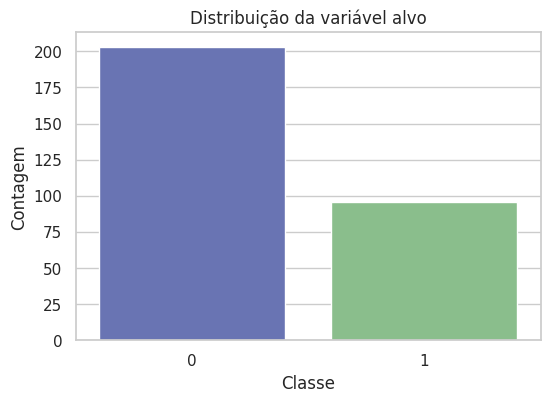

+----------------------------------+
| Boxplots das métricas por modelo |
+----------------------------------+


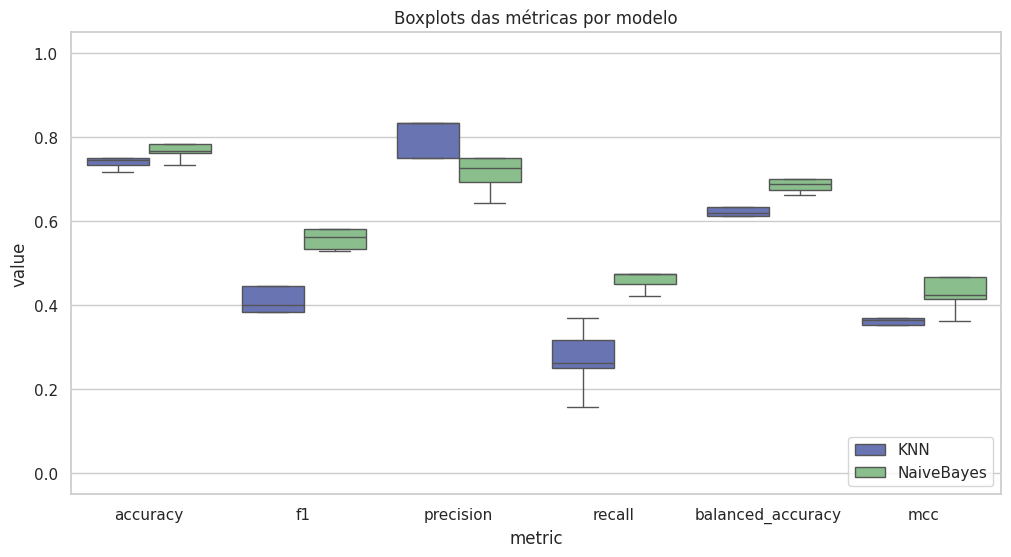

+-------------------------+
| Comparativo de métricas |
+-------------------------+


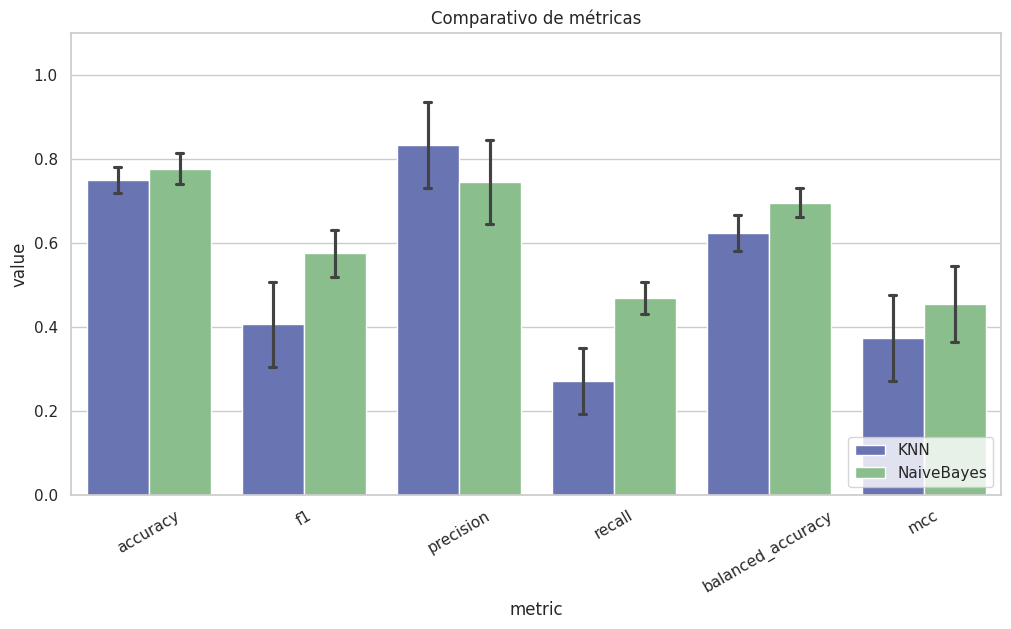

+----------------------+
| Matrizes de confusão |
+----------------------+


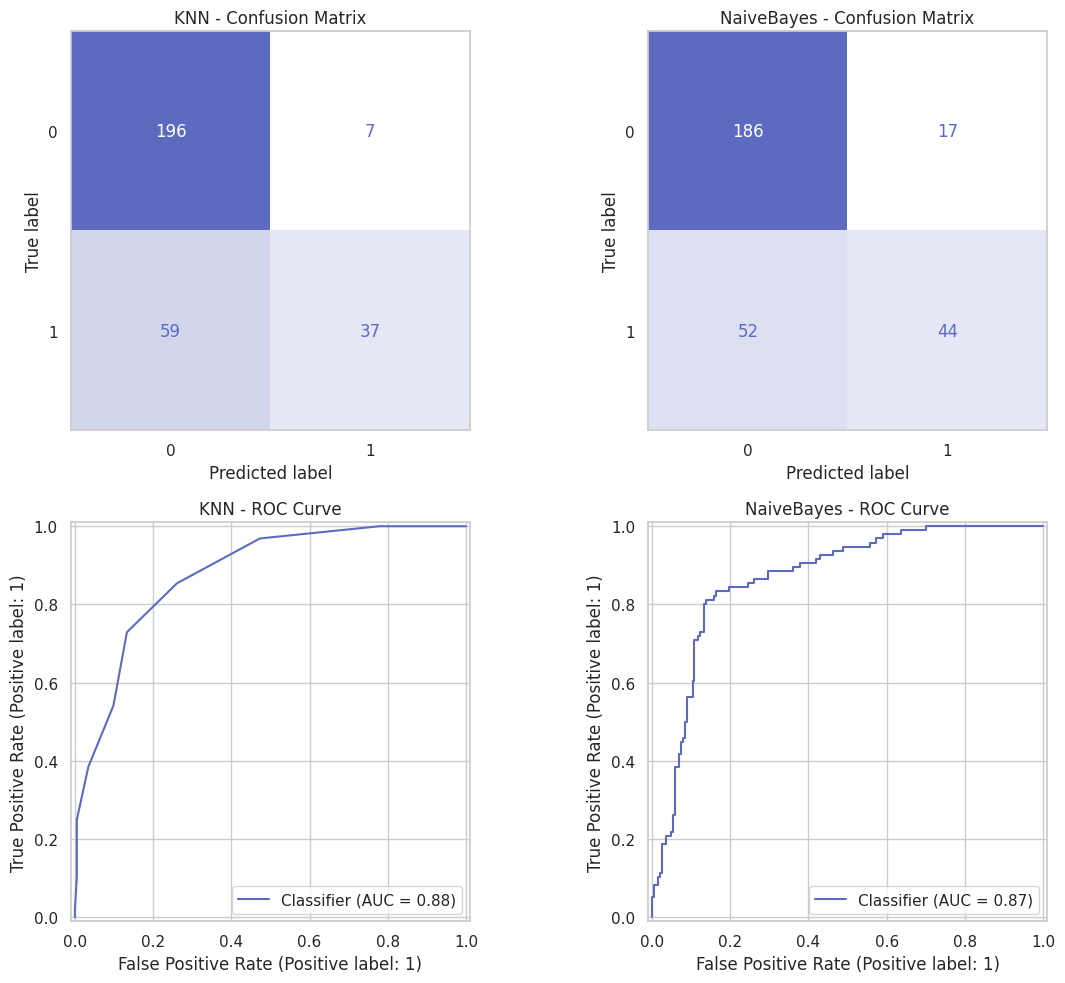

In [69]:
moldura("Gráficos")

sns.set(style='whitegrid', palette=['#5c6bc0', '#81c784'])

moldura("Distribuição da variável alvo")
plt.figure(figsize=(6, 4))
sns.countplot(x=y_enc, palette=['#5c6bc0', '#81c784']) # Usando a paleta definida
plt.title("Distribuição da variável alvo")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks(ticks=[0, 1], labels=le.inverse_transform([0, 1])) # Nomes originais das classes
plt.show()

moldura("Boxplots das métricas por modelo")
metrics_to_plot = ['accuracy','f1','precision','recall','balanced_accuracy','mcc']
long_rows = []
for model_name, df_folds in folds_details.items():
    for fold_idx, row in df_folds.reset_index(drop=True).iterrows():
        for m in metrics_to_plot:
            long_rows.append({'model': model_name, 'fold': fold_idx+1, 'metric': m, 'value': row[m]})
long_df = pd.DataFrame(long_rows)

plt.figure(figsize=(12,6))
sns.boxplot(x='metric', y='value', hue='model', data=long_df, showfliers=False)
plt.title("Boxplots das métricas por modelo")
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

moldura("Comparativo de métricas")
plt.figure(figsize=(12,6))
sns.barplot(
    x='metric', 
    y='value', 
    hue='model', 
    data=long_df, 
    errorbar='sd',  # Adiciona a barra de erro representando o Desvio Padrão
    capsize=0.1     # Adiciona o "chapéu" na barra de erro
)
plt.title("Comparativo de métricas")
plt.ylim(0, 1.1)
plt.xticks(rotation=30)
plt.legend(loc='lower right')
plt.show()

moldura("Matrizes de confusão")
fig, axes = plt.subplots(2, len(clfs), figsize=(6*len(clfs), 10))

if len(clfs) == 1: axes = np.expand_dims(axes, axis=1)

for i, (name, clf) in enumerate(clfs.items()):
    scaler_vis = StandardScaler().fit(X_np)
    Xs = scaler_vis.transform(X_np)
    clf.fit(Xs, y_np)
    
    # probabilidades
    try:
        probs = clf.predict_proba(Xs)
        probs_use = probs[:, 1] if probs.shape[1] == 2 else None
    except:
        probs_use = None
    y_pred_vis = clf.predict(Xs)


    ax_cm = axes[0, i]

    from matplotlib.colors import LinearSegmentedColormap
    hex_color = '#5c6bc0'
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#ffffff", hex_color])
    ConfusionMatrixDisplay(confusion_matrix(y_np, y_pred_vis)).plot(ax=ax_cm, cmap=custom_cmap, colorbar=False)
    ax_cm.set_title(f"{name} - Confusion Matrix")
    
    ax_cm.grid(False)

    # ROC
    ax_roc = axes[1, i]
    if (probs_use is not None) and binary_problem:
        RocCurveDisplay.from_predictions(y_np, probs_use, ax=ax_roc, color=sns.color_palette()[0]) 
        ax_roc.set_title(f"{name} - ROC Curve")
    else:
        ax_roc.text(0.5, 0.5, "ROC N/A", ha='center', va='center')
        ax_roc.set_title(f"{name} - ROC Curve (N/A)")

plt.tight_layout()
plt.show()